In [2]:
import pandas as pd

# load the dataset
zori = pd.read_csv('data/Zip_zori_uc_sfrcondomfr_sm_sa_month.csv')

In [3]:
print(zori.shape)
zori.head()

(7853, 138)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2015-01-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1501.705581,...,1902.035623,1902.589323,1894.295923,1891.247836,1889.899732,1889.783368,1886.582030,1887.378619,1888.256767,1891.123162
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,1252.988450,...,1834.055010,1834.801216,1836.145502,1835.505043,1831.819858,1833.617479,1829.740778,1831.288573,1825.781679,1829.945544
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,1127.656461,...,1625.302516,1624.803898,1632.635241,1632.612081,1630.639582,1615.873819,1614.456853,1619.566427,1630.300973,1634.061782
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,NaN,...,1426.444928,1435.425031,1443.855231,1446.723283,1441.421688,1439.302928,1441.642569,1448.088589,1456.518933,1463.357895
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,3150.113998,3186.884070,3216.427094,3224.476398,3223.466612,3234.890106,3255.649669,3275.779831,3277.512495,3300.138507


In [4]:
def melt_zori_wide_to_long(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert Zillow ZORI 'wide' format (one column per month) into a tidy 'long'
    DataFrame with one row per (state, zip, date) and a numeric `zori` value.

    Steps
    -----
    - Keep identifier columns (RegionID, SizeRank, RegionName, RegionType, StateName,
      State, City, Metro, CountyName).
    - Treat all remaining date-like columns (e.g., 'YYYY-MM-31') as values.
    - Melt to columns: id vars + ['date', 'zori'].
    - Coerce `date` to datetime and `zori` to numeric (invalids -> NaN).
    - Sort rows by state, zip, date for stable downstream processing.

    Returns
    -------
    pd.DataFrame
        Tidy long DataFrame with columns including: state, zip, date, zori, and
        the original ID columns.
    """

    id_cols = [
        "RegionID", "SizeRank", "RegionName", "RegionType", "StateName",
        "State", "City", "Metro", "CountyName"
    ]
    date_cols = [c for c in df.columns if c not in id_cols]
    long = df.melt(
        id_vars=[c for c in id_cols if c in df.columns],
        value_vars=date_cols,
        var_name="date",
        value_name="zori"
    )
    # Coerce date and numeric value
    long["date"] = pd.to_datetime(long["date"], errors="coerce")
    long["zori"] = pd.to_numeric(long["zori"], errors="coerce")
    # Standardize key fields
    if "RegionName" in long.columns:
        long = long.rename(columns={"RegionName": "zip"})
    if "StateName" in long.columns:
        long = long.rename(columns={"StateName": "state_name"})
    if "State" in long.columns:
        long = long.rename(columns={"State": "state"})
    # Keep only rows with a 5-digit ZIP
    long = long[long["zip"].astype(str).str.fullmatch(r"\d{5}", na=False)]
    return long

In [5]:
def basic_eda_summaries(df_long: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """
    Build a set of tiny EDA summary tables from the tidy long ZORI DataFrame.

    Returns
    -------
    dict[str, pd.DataFrame]

    """

    out = {}
    # Overview counts
    overview = pd.DataFrame({
        "n_rows": [len(df_long)],
        "n_zips": [df_long["zip"].nunique()],
        "n_states": [df_long["state"].nunique()],
        "date_min": [df_long["date"].min()],
        "date_max": [df_long["date"].max()],
        "missing_rate": [df_long["zori"].isna().mean()]
    })
    out["overview"] = overview

    # Zip counts by state
    by_state = (df_long.dropna(subset=["zori"])
                        .groupby("state")["zip"].nunique()
                        .reset_index(name="n_zips"))
    out["by_state"] = by_state.sort_values("n_zips", ascending=False)

    # Missingness by state
    miss_by_state = (df_long.assign(is_na=df_long["zori"].isna())
                             .groupby("state")["is_na"]
                             .mean()
                             .reset_index(name="missing_rate"))
    out["missing_by_state"] = miss_by_state.sort_values("missing_rate", ascending=False)

    # Count of months per ZIP (coverage)
    months_per_zip = (df_long.groupby("zip")["date"].nunique()
                              .reset_index(name="n_months"))
    out["months_per_zip"] = months_per_zip.sort_values("n_months", ascending=False)

    return out
    

In [6]:
data = melt_zori_wide_to_long(zori)
summaries = basic_eda_summaries(data)

In [7]:
print(summaries["overview"])

   n_rows  n_zips  n_states   date_min   date_max  missing_rate
0  934089    7241        44 2015-01-31 2025-09-30      0.597091


In [8]:
data.head()

,RegionID,SizeRank,zip,RegionType,state_name,state,City,Metro,CountyName,date,zori
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2015-01-31,1501.705581
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,2015-01-31,1252.988450
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,2015-01-31,1127.656461
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,2015-01-31,NaN
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2015-01-31,NaN


In [9]:
# output_file_path = 'data/zori_tidy_long.csv'
# data.to_csv(output_file_path, index=False)

In [10]:
# Assuming 'date' is already converted to datetime in the original 'data' DataFrame
target_data = data[data['zip'] == 77494].copy()

# 1. Set the index directly on the filtered data
target_data.set_index('date', inplace=True)

# 2. Sort by the new index (date)
target_data.sort_index(inplace=True) 

# 3. Create series, drop NaNs, and set frequency
series = target_data['zori'].copy()
series = series.dropna()
series = series.asfreq('ME') # ME = Month End

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define the model (Holt-Winters Triple Exponential Smoothing)
model = ExponentialSmoothing(
    series,
    seasonal_periods=12,
    trend='add',
    seasonal='add',
    initialization_method='estimated'
)

# Fit the model to the data
fit = model.fit(optimized=True)

# Define the length of the forecast (e.g., 12 months)
forecast_length = 12

# Generate the forecast
forecast = fit.forecast(forecast_length)

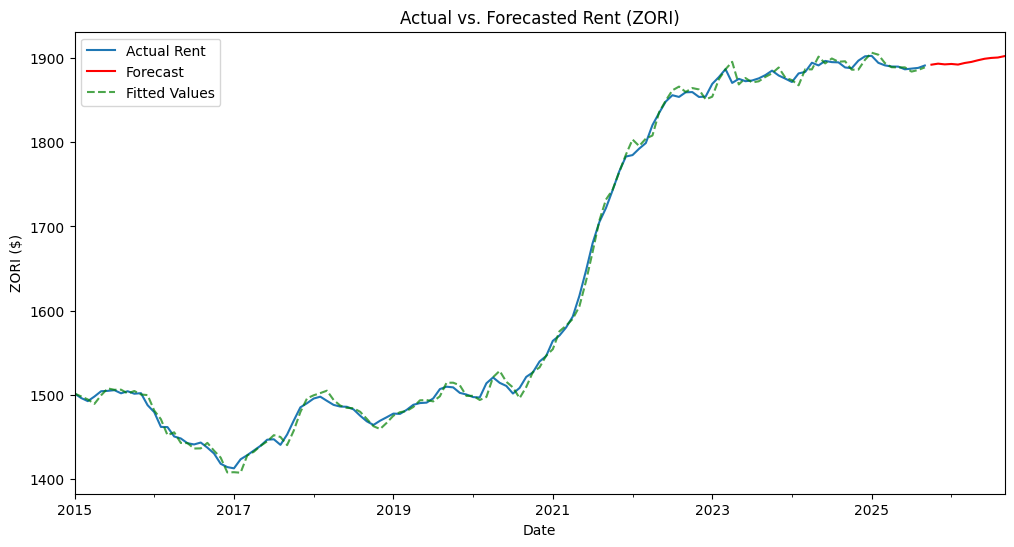

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create a date index for the 12 forecast months
last_date = series.index.max()
future_dates = pd.date_range(start=last_date, periods=forecast_length + 1, freq='ME')[1:]

# Create a DataFrame to hold the results
df_final = pd.DataFrame({
    'date': series.index.append(future_dates)
})

# Add Actual Rent (NaN for future dates)
df_final['Actual Rent'] = series.tolist() + [np.nan] * forecast_length

# Add Forecast Rent (Fitted values for past + Forecast values for future)
df_final['Forecast Rent'] = fit.fittedvalues.tolist() + forecast.tolist()

# Plot the results
plt.figure(figsize=(12, 6))
series.plot(label='Actual Rent')
forecast.plot(label='Forecast', color='red')
fit.fittedvalues.plot(label='Fitted Values', linestyle='--', color='green', alpha=0.7)
plt.title('Actual vs. Forecasted Rent (ZORI)')
plt.ylabel('ZORI ($)')

plt.xlabel('Date')
plt.legend()
plt.show()